# Salt Lake City Current Active Listings

## Scraping Zillow, Cleaning the Data, and Assigning Geographic Categories

In [1]:
import pandas as pd
import urllib.parse
from matplotlib import pyplot as plt
%matplotlib inline
import requests
import json
from bs4 import BeautifulSoup
import lxml
import csv
import re
import numpy as np
import seaborn as sns

## Formatting the scraped data for active listings

I modified a script to scrape address and other info from Zillow listings based on zip code
reference: https://gist.github.com/scrapehero/5f51f344d68cf2c022eb2d23a2f1cf95

I modified the original script to proceed through multiple search pages, added time between get calls to avoid blacklisting, and added logic to deal with some duplicate data (not sure why this happened).

I then called using a list of 27 zip codes for Salt Lake City. I got a csv file with 833 unique listings.

#### Generating and Loading the data

In [ ]:
###    Formatting the scraped data for active listings    ###

#Modified a script to scrape address and other info from Zillow listings based on zip code
#(original script at https://gist.github.com/scrapehero/5f51f344d68cf2c022eb2d23a2f1cf95)

# Modifications were made to proceed through multiple search pages, 
# add time between get calls (to avoid blacklisting), 
# and deal with some duplicate data

# Scraping script was run on list of Salt Lake City zip codes (27 unique codes) 
# using a 'calling script' and the output was saved to a csv file

Zillow_scraper_pycode jeff$ python zillow_scraper_calls.py


In [3]:
# after saving the csv it was opened in a pandas data frame
address_data = pd.read_csv('~/Desktop/K2_DataScience/K2_Project2/zillow_scraper_pycode/properties-slc.csv', 
                           sep=',')

# this display option will make it easier to see price data
pd.options.display.float_format = '{:20,.2f}'.format

#### Data formatting

In [4]:
# don't need real estate provider info so I'll drop this

address_data.drop(['real estate provider'], axis = 1, inplace=True)

In [5]:
# extracted zpid from listing url field and used as index

zpid_list = []
for url in address_data['url']:
    zpid_list.append((((url.split("/")[-2:-1])[0]).split("_")[0]))

address_data['zpid'] = zpid_list

address_data.set_index('zpid', inplace=True)

In [6]:
# fixed inconsistancies in price formatting and converted to as numeric

address_data[['price']] = address_data[['price']].replace('[\$,]','',regex=True)
address_data[['price']] = address_data[['price']].replace('[K,]','000',regex=True)
address_data[['price']] = address_data[['price']].replace('[+,]','',regex=True)
address_data[['price']] = address_data[['price']].replace('[.,]','',regex=True)
address_data[['price']] = address_data[['price']].replace('[M,]','0000',regex=True)
address_data['price'] = pd.to_numeric(address_data['price'])

In [7]:
# formatted all cities to upper case for consistency

address_data['city']= address_data['city'].str.upper()

# manually fixed inconsistancies in city names

address_data[['city']] = address_data[['city']].replace('SLC','SALT LAKE CITY',regex=False)
address_data[['city']] = address_data[['city']].replace('SALT LAKE','SALT LAKE CITY',regex=False)
address_data[['city']] = address_data[['city']].replace('WEST VALLEY','WEST VALLEY CITY',regex=False)

In [8]:
# create a dictionary of facts and features indexed by zpid

fact_feat_dict = {}
for fact_feat in address_data['facts and features'].iteritems():
    if fact_feat[1].endswith('sqft'): # checking for typical structure
        zpid = fact_feat[0]
        string = (fact_feat[1])
        #parsing number of beds
        beds = (re.sub('\sbds?', '', re.split(" , ", string)[0]))
        beds = (beds.replace('Studio', '0'))
        beds = (beds.replace('--', '0'))
        #parsing number of baths
        baths = (re.sub('\sba', '', re.split(" , ", string)[1]))
        baths = (baths.replace('--', '0'))
        #parsing square footage
        sqft = (re.sub('\ssqft', '', re.split(" , ", string)[2]))
        sqft = (sqft.replace('--', '0'))
        sqft = (sqft.replace(',', ''))
        sqft = (sqft.replace('+', ''))
        #saving data to dict with zillow index as key
        temp_dict = {'beds': beds, 'baths': baths, 'sqft': sqft}
        fact_feat_dict[zpid] = temp_dict
    else:         #if structure isn't the normal structure, NaNs are added for room count
        zpid = fact_feat[0]
        temp_dict = {'beds': np.NaN, 'baths': np.NaN, 'sqft': np.NaN}
        fact_feat_dict[zpid] = temp_dict
        
print(fact_feat_dict)

{'2090375808': {'beds': '1', 'baths': '1', 'sqft': '753'}, '2090452983': {'beds': '1', 'baths': '1', 'sqft': '763'}, '83826154': {'beds': '1', 'baths': '1', 'sqft': '893'}, '65733953': {'beds': '1', 'baths': '1', 'sqft': '750'}, '65729920': {'beds': '2', 'baths': '2', 'sqft': '1160'}, '52834472': {'beds': '1', 'baths': '1', 'sqft': '886'}, '12735293': {'beds': '3', 'baths': '3', 'sqft': '1691'}, '89425336': {'beds': '1', 'baths': '3', 'sqft': '2336'}, '2092527388': {'beds': '3', 'baths': '3', 'sqft': '1560'}, '2090952751': {'beds': '2', 'baths': '2', 'sqft': '692'}, '65729905': {'beds': '2', 'baths': '2', 'sqft': '864'}, '89421785': {'beds': '2', 'baths': '1', 'sqft': '790'}, '65434493': {'beds': '2', 'baths': '2', 'sqft': '1198'}, '117876609': {'beds': '3', 'baths': '2', 'sqft': '2296'}, '2090814887': {'beds': '0', 'baths': '1', 'sqft': '524'}, '89417744': {'beds': '2', 'baths': '1', 'sqft': '859'}, '118556148': {'beds': '4', 'baths': '3', 'sqft': '3093'}, '12735434': {'beds': '2', 'b

In [9]:
# create a facts and features data frame and cast as floats

fact_features_df = pd.DataFrame.from_dict(fact_feat_dict, orient='index')
fact_features_df['beds'] = pd.to_numeric(fact_features_df['beds'])
fact_features_df['baths'] = pd.to_numeric(fact_features_df['baths'])
fact_features_df['sqft'] = pd.to_numeric(fact_features_df['sqft'])

In [10]:
# join facts and features to the existing data frame
address_data = address_data.join(fact_features_df, how='left')

## Checking for Missing Data

In [11]:
address_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 840 entries, 2090375808 to 124782718
Data columns (total 11 columns):
title                 840 non-null object
address               840 non-null object
city                  840 non-null object
state                 840 non-null object
postal_code           840 non-null int64
price                 836 non-null float64
facts and features    840 non-null object
url                   840 non-null object
beds                  774 non-null float64
baths                 774 non-null float64
sqft                  774 non-null float64
dtypes: float64(4), int64(1), object(6)
memory usage: 118.8+ KB


In [12]:
# test to see if the 'null' objects for the parsed figures (bed, bath, sqft) are incorrectly assigned

misclassified_test_nans = (address_data[((np.isnan(address_data.beds)) | 
                      (np.isnan(address_data.baths)) |
                     (np.isnan(address_data.sqft))) & 
                     (address_data['title'] != 'Lot/Land For Sale')])
len(misclassified_test_nans)

2

In [13]:
# test to see if the '0' objects for the parsed figures (bed, bath, sqft) are incorrectly assigned

misclassified_test_zeros = (address_data[(address_data['title'] != 'Lot/Land For Sale') & 
                     ((address_data['beds'] == 0) | 
                      (address_data['baths'] == 0) |
                      (address_data['sqft'] == 0)
                     )])
len(misclassified_test_zeros)                

17

In [14]:
# all items seem to be parsed satisfactorally
# 0 values for bed, bath, and sqft will be converted to nan so they don't skew the data

cols = ['beds', 'baths', 'sqft']
address_data[cols] = address_data[cols].replace({0:np.nan})

In [15]:
# filtering out listings with nan for price (mostly auctions)
address_data = address_data[np.isnan(address_data.price)==False]

## Exploring the Data

In [16]:
address_data.groupby('beds')['sqft'].describe()

,count,mean,std,min,25%,50%,75%,max
beds,,,,,,,,
1.00,20.00,927.30,436.97,471.00,683.00,759.50,952.50,"2,336.00"
2.00,138.00,"1,367.72",577.61,649.00,"1,005.75","1,202.00","1,572.00","4,804.00"
3.00,225.00,"2,143.48",958.07,880.00,"1,450.00","1,900.00","2,479.00","6,200.00"
4.00,184.00,"3,177.95","1,750.98","1,205.00","1,990.00","2,696.00","3,781.00","11,646.00"
5.00,113.00,"4,621.65","3,864.38","1,471.00","2,748.00","3,600.00","4,990.00","32,463.00"
6.00,57.00,"5,193.11","1,856.41","1,944.00","3,612.00","5,359.00","6,050.00","9,414.00"
7.00,19.00,"6,839.26","2,854.74","2,530.00","4,409.00","5,842.00","8,889.50","12,980.00"
8.00,3.00,"4,694.33","1,742.84","3,268.00","3,723.00","4,178.00","5,407.50","6,637.00"
9.00,1.00,"7,126.00",nan,"7,126.00","7,126.00","7,126.00","7,126.00","7,126.00"


In [17]:
address_data['sqft'].describe()

count                 767.00
mean                2,950.96
std                 2,395.65
min                   432.00
25%                 1,505.50
50%                 2,200.00
75%                 3,639.50
max                32,463.00
Name: sqft, dtype: float64

In [18]:
address_data['postal_code'].unique()

array([84101, 84102, 84103, 84104, 84105, 84106, 84107, 84108, 84109,
       84111, 84114, 84115, 84054, 84119, 84116, 84117, 84118, 84120,
       84121, 84123, 84124, 84128, 84129, 84010, 84087])

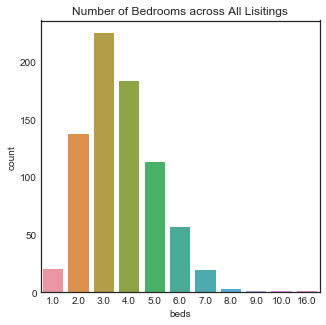

In [19]:
# plotting the number of bedrooms across all listings
sns.set_style("white")
data = address_data
fig = plt.figure(figsize=[5, 5])
ax = fig.add_subplot(111)
ax = sns.countplot(x="beds", data=data).set_title('Number of Bedrooms across All Lisitings')

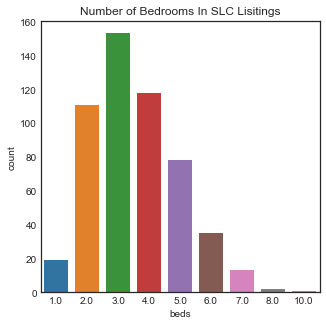

In [20]:
# plotting the number of bedrooms in slc listings
sns.set_style("white")
data= address_data[address_data['city'] == 'SALT LAKE CITY']
fig = plt.figure(figsize=[5, 5])
ax = fig.add_subplot(111)
ax = sns.countplot(x="beds", data=data).set_title('Number of Bedrooms In SLC Lisitings')

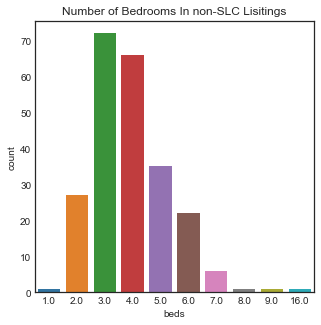

In [21]:
# plotting the number of bedrooms in non-slc listings
sns.set_style("white")
data= address_data[address_data['city'] != 'SALT LAKE CITY']
fig = plt.figure(figsize=[5, 5])
ax = fig.add_subplot(111)
ax = sns.countplot(x="beds", data=data).set_title('Number of Bedrooms In non-SLC Lisitings')

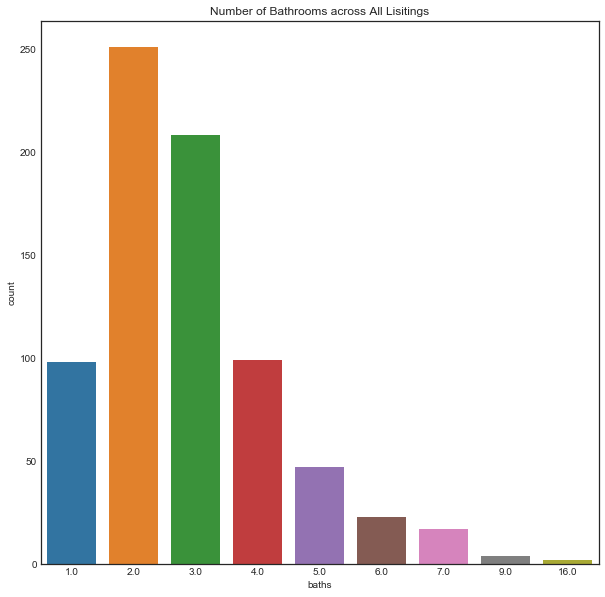

In [22]:
# plotting the number of bathrooms across all listings
data = address_data[(address_data['baths'] !=1.5) & 
                    (address_data['baths'] !=1.75) &
                   (address_data['baths'] != 2.5) &
                   (address_data['baths'] != 2.75) &
                   (address_data['baths'] != 3.5) &
                   (address_data['baths'] != 5.5)]
fig = plt.figure(figsize=[10, 10])
ax = fig.add_subplot(111)
ax = sns.countplot(x="baths", data=data).set_title('Number of Bathrooms across All Lisitings')

(100, 12000)

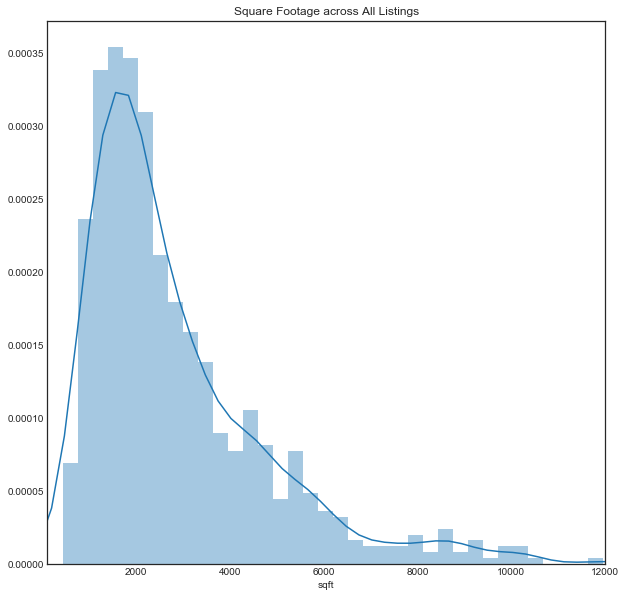

In [23]:
# plotting the square footage across all listings
data = address_data[np.isnan(address_data.sqft)==False]
fig = plt.figure(figsize=[10, 10])
ax = fig.add_subplot(111)
count = sns.distplot(data['sqft'], bins = 100).set_title('Square Footage across All Listings')
plt.xlim(100, 12000)

In [24]:
address_data.groupby('city')['sqft'].describe()

,count,mean,std,min,25%,50%,75%,max
city,,,,,,,,
BOUNTIFUL,3.00,"2,786.00",944.36,"1,957.00","2,272.00","2,587.00","3,200.50","3,814.00"
BRIGHTON,11.00,"2,164.27","2,012.80",433.00,951.00,990.00,"3,148.00","6,709.00"
COTTONWOOD HEIGHTS,9.00,"5,194.89","1,882.31","2,722.00","3,668.00","5,469.00","6,414.00","8,001.00"
EMIGRATION CANYON,1.00,"5,408.00",nan,"5,408.00","5,408.00","5,408.00","5,408.00","5,408.00"
HOLLADAY,43.00,"5,221.26","4,886.59","1,458.00","2,893.50","4,013.00","5,619.00","32,463.00"
KEARNS,2.00,"2,457.50",946.82,"1,788.00","2,122.75","2,457.50","2,792.25","3,127.00"
MILLCREEK,13.00,"3,223.77","1,182.56","1,348.00","2,775.00","3,148.00","3,794.00","5,249.00"
MURRAY,21.00,"2,818.81","2,028.11",658.00,"1,391.00","1,864.00","3,796.00","8,800.00"
NORTH SALT LAKE,5.00,"3,014.60","1,641.85","1,380.00","1,920.00","2,602.00","3,635.00","5,536.00"


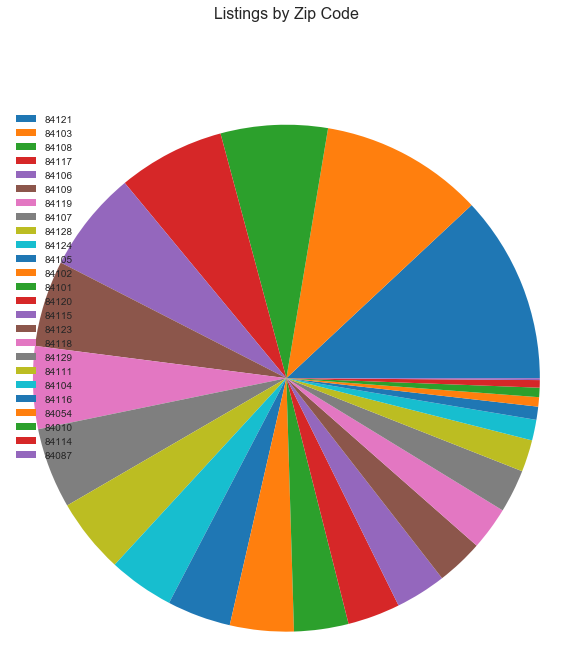

In [25]:
# make df with counts of zip code occurances
# this plot is meaningless. Created a geographically clustered feature below.

df= pd.DataFrame(data=address_data['postal_code'].value_counts(), index=None).reset_index()
df.columns = ['zip_code', 'listing_count']

values = df['listing_count']
labels = df['zip_code']

fig = plt.figure(figsize=[10, 10])
ax = fig.add_subplot(111)
plt.pie(values)
plt.legend(labels, loc="best")
plt.title('Listings by Zip Code', y=1.15, fontsize=16)
plt.axis('equal')
plt.show()

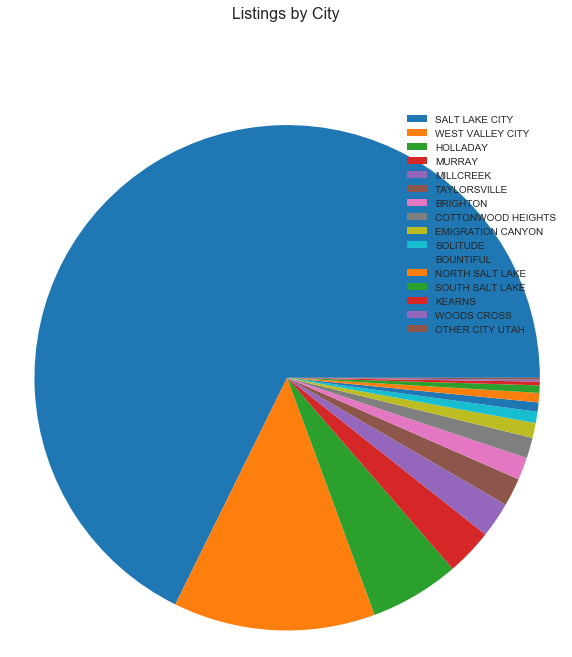

In [26]:
#make df with counts of city occurances
# this plot is meaningless. Created a geographically clustered feature below.

df= pd.DataFrame(data=address_data['city'].value_counts(), index=None).reset_index()
df.columns = ['city', 'listing_count']

values = df['listing_count']
labels = df['city']

fig = plt.figure(figsize=[10, 10])
ax = fig.add_subplot(111)
plt.pie(values,)
plt.legend(labels, loc="best")
plt.title('Listings by City', y=1.15, fontsize=16)
plt.axis('equal')
plt.show()

## Adding a neighborhood feature
The data could be sorted by zipcode (27 count) or city (16 count), but neither of these was providing the granularity I wanted. I created a csv that mapped zip codes to just 8 regions (or neighborhoods).

In [29]:
# created csv of zip mapped to neighborhood
zip_to_neighborhood = pd.read_csv('~/Desktop/K2_DataScience/K2_Project2/zillow_analysis_notebooks/zip_codes_to_neighborhood.csv', 
                           sep=',')

In [30]:
# merge data frames and assigning zpid to column

address_data = address_data.reset_index().merge(zip_to_neighborhood, on='postal_code', how="left")

# reassigning zpid to index

address_data = address_data.set_index('zpid')

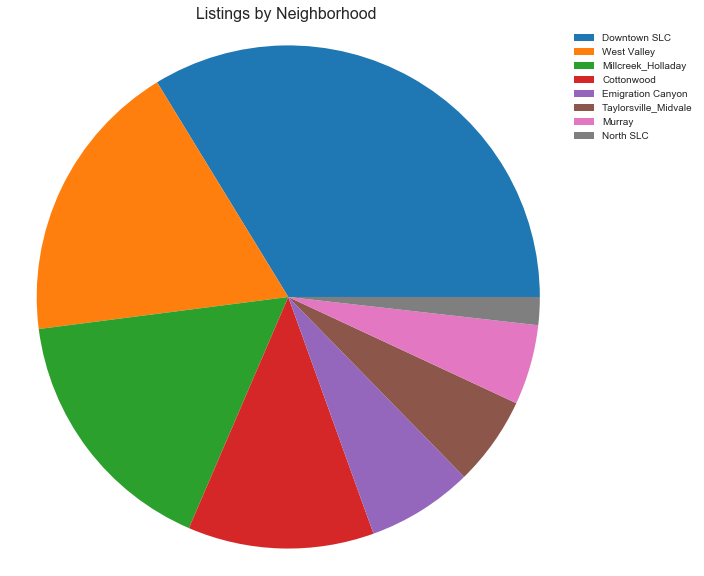

In [31]:
# make df with counts of neighborhood occurances

df= pd.DataFrame(data=address_data['neighborhood'].value_counts(), index=None).reset_index()
df.columns = ['neighborhood', 'listing_count']

values = df['listing_count']
labels = df['neighborhood']

fig = plt.figure(figsize=[10, 10])
ax = fig.add_subplot(111)
plt.pie(values,)
plt.legend(labels, bbox_to_anchor = [1, 1])
plt.title('Listings by Neighborhood', y=1, fontsize=16)
plt.axis('equal')
plt.show()

In [32]:
address_data.groupby('neighborhood').describe()

baths                       \
                                    count                 mean   
neighborhood                                                     
Cottonwood                          93.00                 4.04   
Downtown SLC                       265.00                 2.64   
Emigration Canyon                   42.00                 3.18   
Millcreek_Holladay                 124.00                 3.37   
Murray                              38.00                 2.89   
North SLC                           13.00                 2.85   
Taylorsville_Midvale                45.00                 2.54   
West Valley                        140.00                 2.29   

                                                                \
                                      std                  min   
neighborhood                                                     
Cottonwood                           2.49                 1.00   
Downtown SLC                         1.54                 1.00   
Emigration Canyon                    1.16                 1.75   
Millcreek_Holladay                   1.38                 1.00   
Murray                               1.03                 1.00   
North SLC                            0.69                 2.00   
Taylorsville_Midvale                 1.08                 1.00   
West Valley                          0.79                 1.00   

                                                                \
                                      25%                  50%   
neighborhood                                                     
Cottonwood                           2.00                 4.00   
Downtown SLC                         2.00                 2.00   
Emigration Canyon                    2.00                 3.00   
Millcreek_Holladay                   3.00                 3.00   
Murray                               2.00                 3.00   
North SLC                            2.00                 3.00   
Taylorsville_Midvale                 2.00                 2.00   
West Valley                          2.00                 2.00   

                                                                \
                                      75%                  max   
neighborhood                                                     
Cottonwood                           5.00                16.00   
Downtown SLC                         3.00                 9.00   
Emigration Canyon                    4.00                 6.00   
Millcreek_Holladay                   4.00                 9.00   
Murray                               4.00                 5.00   
North SLC                            3.00                 4.00   
Taylorsville_Midvale                 3.00                 6.00   
West Valley                          3.00                 4.00   

                                     beds                       \
                                    count                 mean   
neighborhood                                                     
Cottonwood                          91.00                 4.59   
Downtown SLC                       267.00                 3.24   
Emigration Canyon                   42.00                 3.83   
Millcreek_Holladay                 124.00                 3.98   
Murray                              39.00                 3.79   
North SLC                           13.00                 3.62   
Taylorsville_Midvale                45.00                 3.76   
West Valley                        141.00                 3.58   

                             ...                         price  \
                             ...                           75%   
neighborhood                 ...                                 
Cottonwood                   ...                  1,231,250.00   
Downtown SLC                 ...                    746,500.00   
Emigration Canyon            ...                    995,000.00   
Millc

## Now that we have neighborhood, let's take another look at some listing metrics

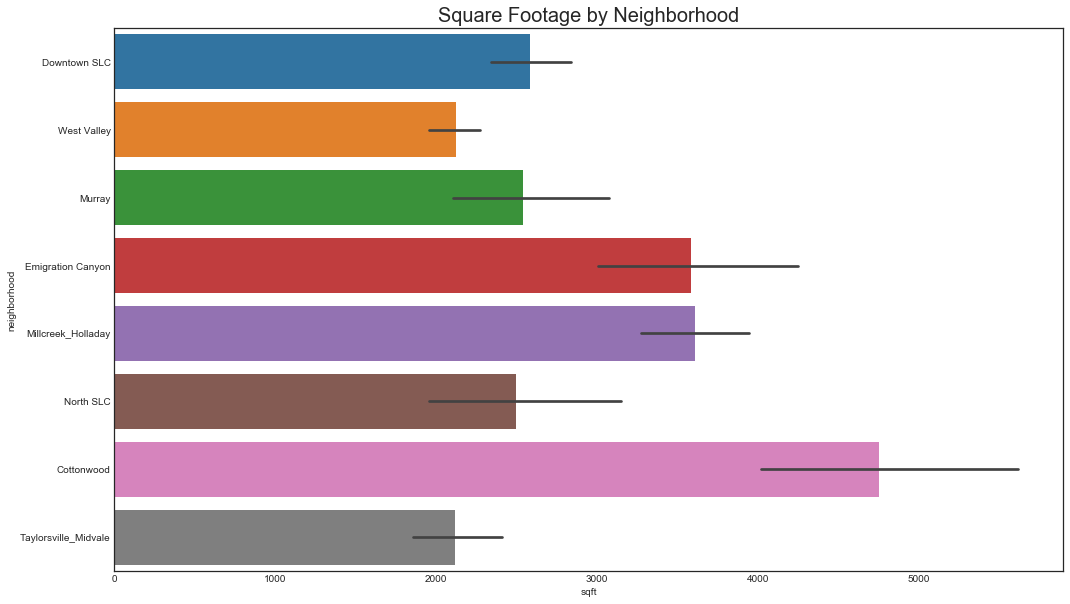

In [33]:
#plotting square footage by neighborhood
fig = plt.figure(figsize=[17, 10])
ax = sns.barplot(y="neighborhood", x="sqft", data=address_data)
plt.title('Square Footage by Neighborhood', y=1, fontsize=20)
plt.show()

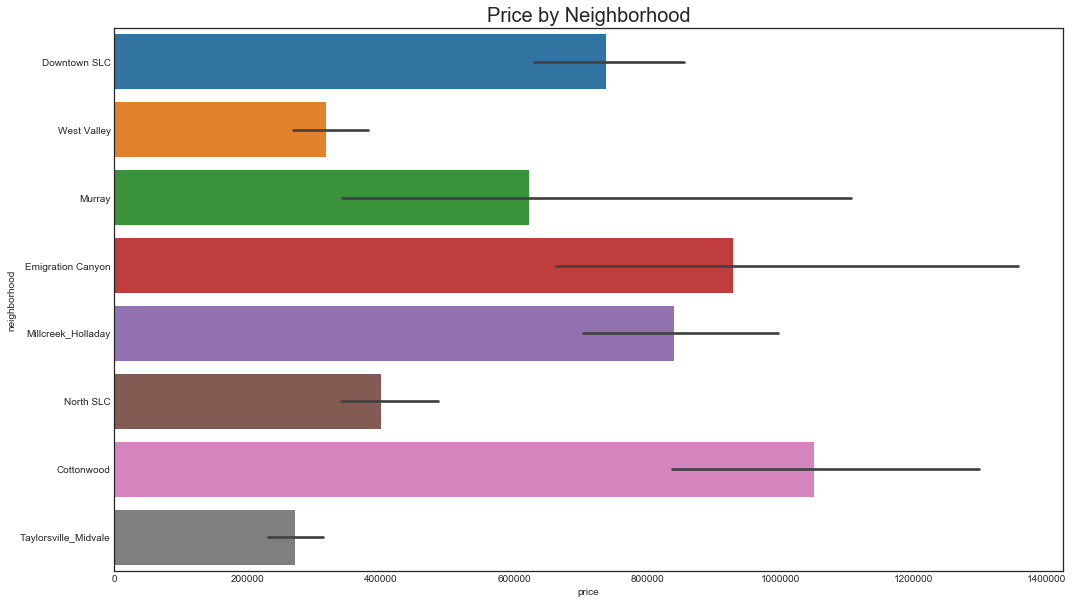

In [34]:
#plotting price by neighborhood
fig = plt.figure(figsize=[17, 10])
ax = sns.barplot(y="neighborhood", x="price", data=address_data)
plt.title('Price by Neighborhood', y=1, fontsize=20)
plt.show()

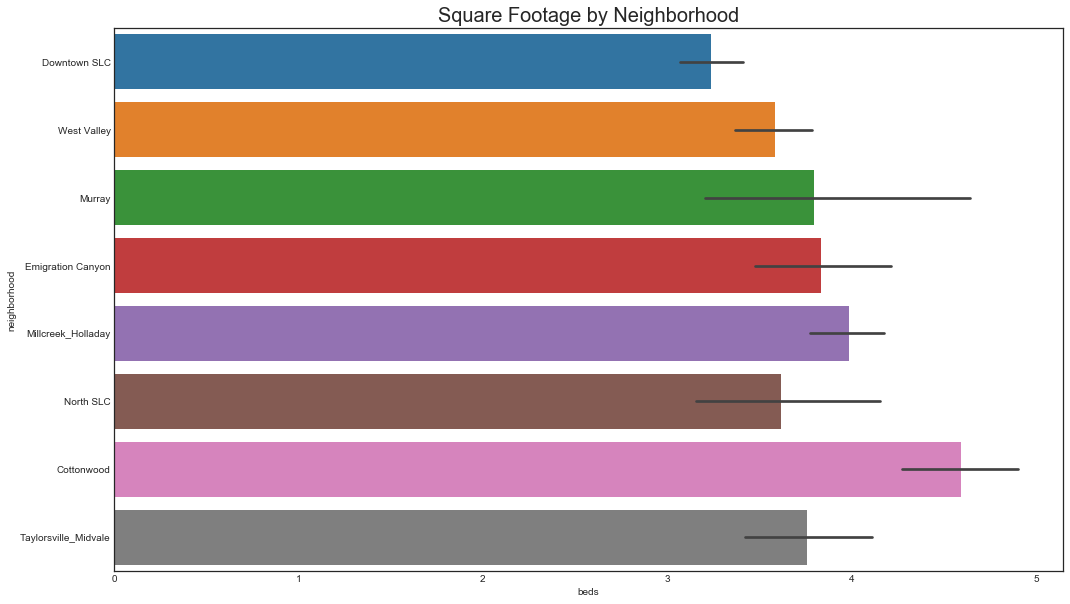

In [35]:
#plotting bedrooms footage by neighborhood
fig = plt.figure(figsize=[17, 10])
ax = sns.barplot(y="neighborhood", x="beds", data=address_data)
plt.title('Square Footage by Neighborhood', y=1, fontsize=20)
plt.show()

## Subset the data into three broad regions

I subset the data further based on three geographic regions: 'Downtown-SLC', 'East-SLC', and 'West-SLC' and plotted size (in square feet) and price for these regions.

In [36]:
# subseting into west, east, and downtown neighborhoods
data_slc = address_data[address_data['neighborhood'] == 'Downtown SLC']
data_slc_east = address_data[(address_data['neighborhood'] == 'Cottonwood') |
                            (address_data['neighborhood'] == 'Millcreek_Holladay') |
                            (address_data['neighborhood'] == 'Emigration Canyon,') ]
data_slc_west = address_data[(address_data['neighborhood'] == 'Murray') |
                            (address_data['neighborhood'] == 'North SLC') |
                            (address_data['neighborhood'] == 'Taylorsville_Midvale') |
                            (address_data['neighborhood'] == 'West Valley')]

# removed listings with no information for square footage
#data_slc = data_slc[np.isnan(data_slc.sqft)==False]
#data_slc_east = data_slc_east[np.isnan(data_slc_east.sqft)==False]
#data_slc_west = data_slc_west[np.isnan(data_slc_west.sqft)==False]

# adding 'region' category and concantenating into one data frame

data_slc['region'] = 'Downtown-SLC'
data_slc_east['region'] = 'East-SLC'
data_slc_west['region'] = 'West-SLC'
address_data = pd.concat([data_slc, data_slc_east, data_slc_west])

/Users/jeff/anaconda/lib/python3.6/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/jeff/anaconda/lib/python3.6/site-packages/ipykernel/__main__.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/jeff/anaconda/lib/python3.6/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/in

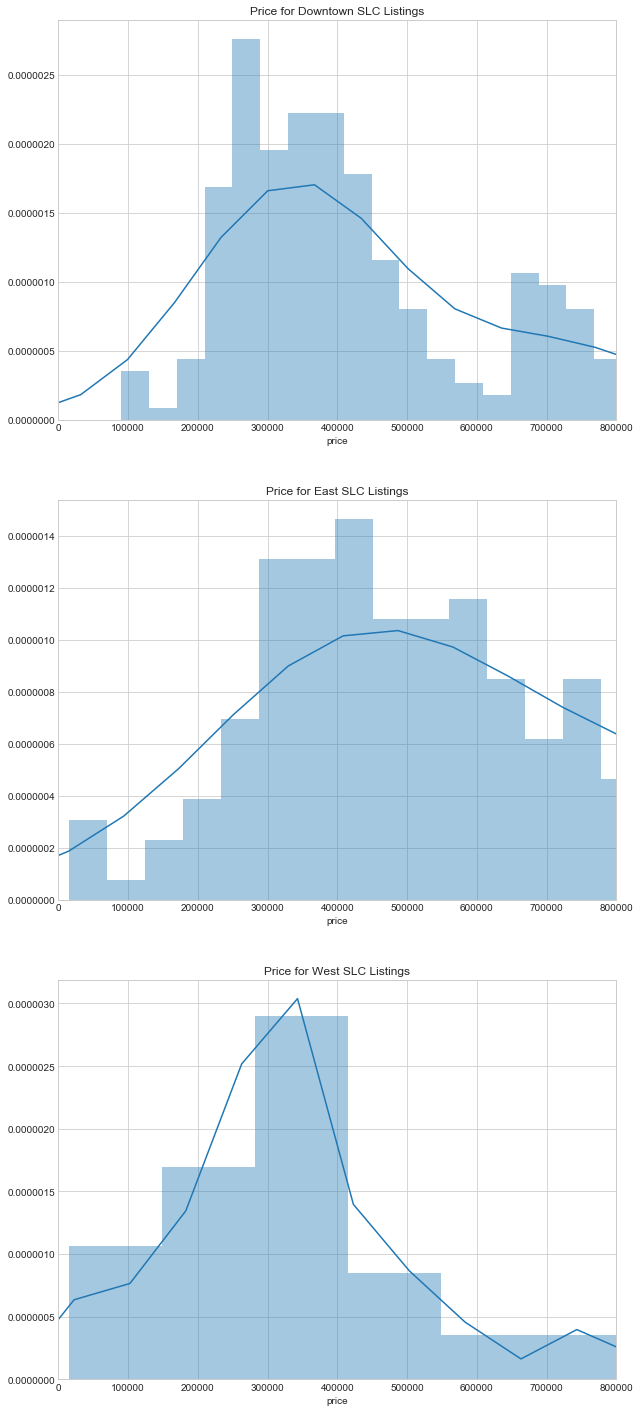

In [37]:
# plotting the price across west, east, and downtown neighborhoods
data_slc = address_data[address_data['neighborhood'] == 'Downtown SLC']
data_slc_east = address_data[(address_data['neighborhood'] == 'Cottonwood') |
                            (address_data['neighborhood'] == 'Millcreek_Holladay') |
                            (address_data['neighborhood'] == 'Emigration Canyo,') ]
data_slc_west = address_data[(address_data['neighborhood'] == 'Murray') |
                            (address_data['neighborhood'] == 'North SLC') |
                            (address_data['neighborhood'] == 'Taylorsville_Midvale') ]
sns.set_style("whitegrid")
fig = plt.figure(figsize=[10, 25])

x = 0.7
upper = 800000

fig.add_subplot(311)   #top left
plot1 =data_slc['price']
sns.distplot(plot1, bins = int(len(data_slc)*x), kde=True).set_title('Price for Downtown SLC Listings')
plt.xlim(100, upper)


fig.add_subplot(312)   #top right
plot2 =data_slc_east['price']
sns.distplot(plot2, bins = int(len(data_slc_east)*x) , kde=True).set_title('Price for East SLC Listings')
plt.xlim(100, upper)


fig.add_subplot(313)   #top right
plot3 =data_slc_west['price']
sns.distplot(plot3, bins = int(len(data_slc_west)*x) , kde=True).set_title('Price for West SLC Listings')
plt.xlim(100, upper)

plt.show()

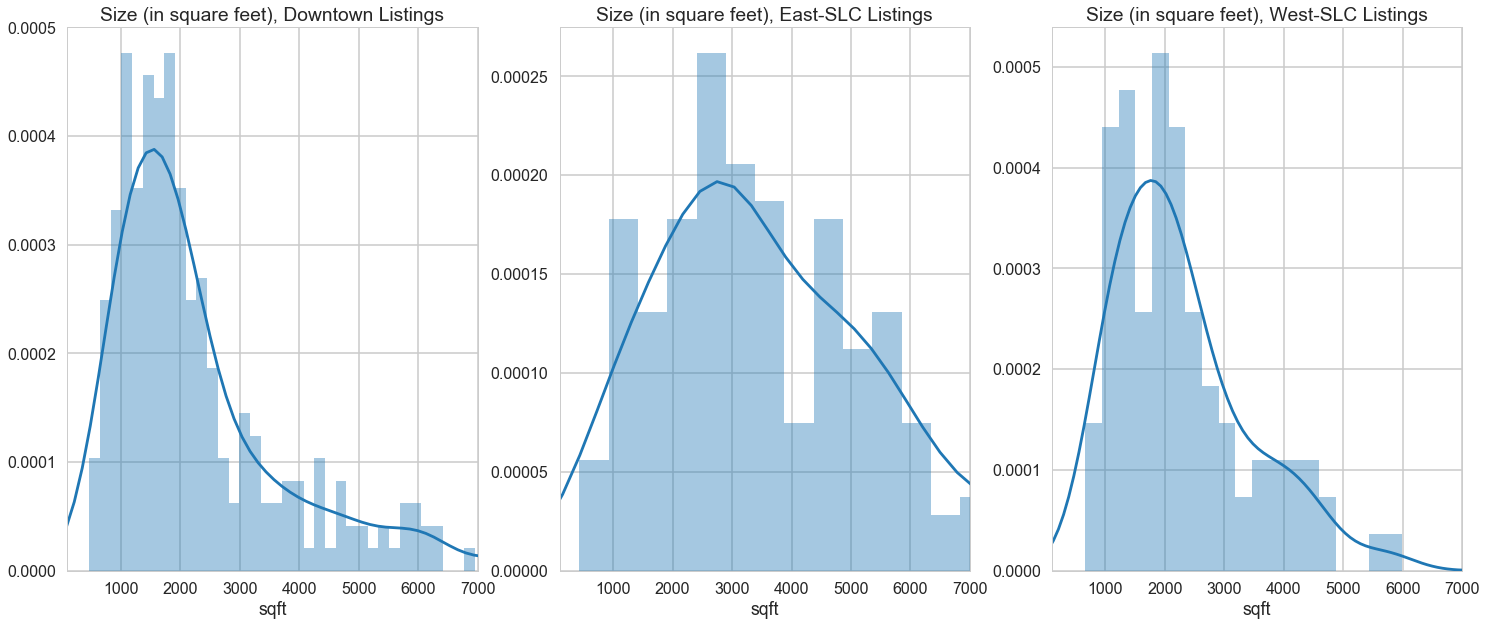

In [38]:
# plotting the price across west, east, and downtown neighborhoods
data_slc = address_data[address_data['neighborhood'] == 'Downtown SLC']
data_slc_east = address_data[(address_data['neighborhood'] == 'Cottonwood') |
                            (address_data['neighborhood'] == 'Millcreek_Holladay') |
                            (address_data['neighborhood'] == 'Emigration Canyo,') ]
data_slc_west = address_data[(address_data['neighborhood'] == 'Murray') |
                            (address_data['neighborhood'] == 'North SLC') |
                            (address_data['neighborhood'] == 'Taylorsville_Midvale') ]

data_slc = data_slc[np.isnan(data_slc.sqft)==False]
data_slc_east = data_slc_east[np.isnan(data_slc_east.sqft)==False]
data_slc_west = data_slc_west[np.isnan(data_slc_west.sqft)==False]

fig = plt.figure(figsize=[25, 10])
sns.set_context("poster")
sns.set_style("whitegrid")

x = 0.3
lower = 100
upper = 7000

fig.add_subplot(131)   #top left
plot1 =data_slc['sqft']
sns.distplot(plot1, bins = int(len(data_slc)*x), kde=True).set_title('Size (in square feet), Downtown Listings')
plt.xlim(lower, upper)


fig.add_subplot(132)   #top right
plot2 =data_slc_east['sqft']
sns.distplot(plot2, bins = int(len(data_slc_east)*x) , kde=True).set_title('Size (in square feet), East-SLC Listings')
plt.xlim(lower, upper)


fig.add_subplot(133)   #top right
plot3 =data_slc_west['sqft']
sns.distplot(plot3, bins = int(len(data_slc_west)*x) , kde=True).set_title('Size (in square feet), West-SLC Listings')
plt.xlim(lower, upper)

plt.show()

In [39]:
home_title = address_data[address_data['title'] =='Home For Sale']
home_title['neighborhood'].value_counts()

West Valley             12
Taylorsville_Midvale     8
Murray                   2
Millcreek_Holladay       2
Name: neighborhood, dtype: int64

### Generate a new feature for price/sqft

In [40]:
address_data['price_per_sqft'] = (address_data['price'])/ (address_data['sqft'])

In [41]:
address_data.groupby('neighborhood')['price_per_sqft'].describe()

,count,mean,std,min,25%,50%,75%,max
neighborhood,,,,,,,,
Cottonwood,93.00,244.01,157.95,125.47,153.80,174.30,283.20,"1,267.88"
Downtown SLC,268.00,263.16,106.32,127.19,191.16,236.82,305.01,868.90
Millcreek_Holladay,124.00,206.15,86.34,16.67,156.04,191.47,230.39,623.30
Murray,39.00,159.55,52.79,22.80,131.32,162.88,198.11,270.93
North SLC,13.00,176.77,42.44,108.67,139.16,166.79,213.77,243.66
Taylorsville_Midvale,45.00,120.95,50.39,18.37,110.23,130.03,143.48,299.24
West Valley,143.00,130.92,43.68,13.64,113.99,136.72,152.53,279.72


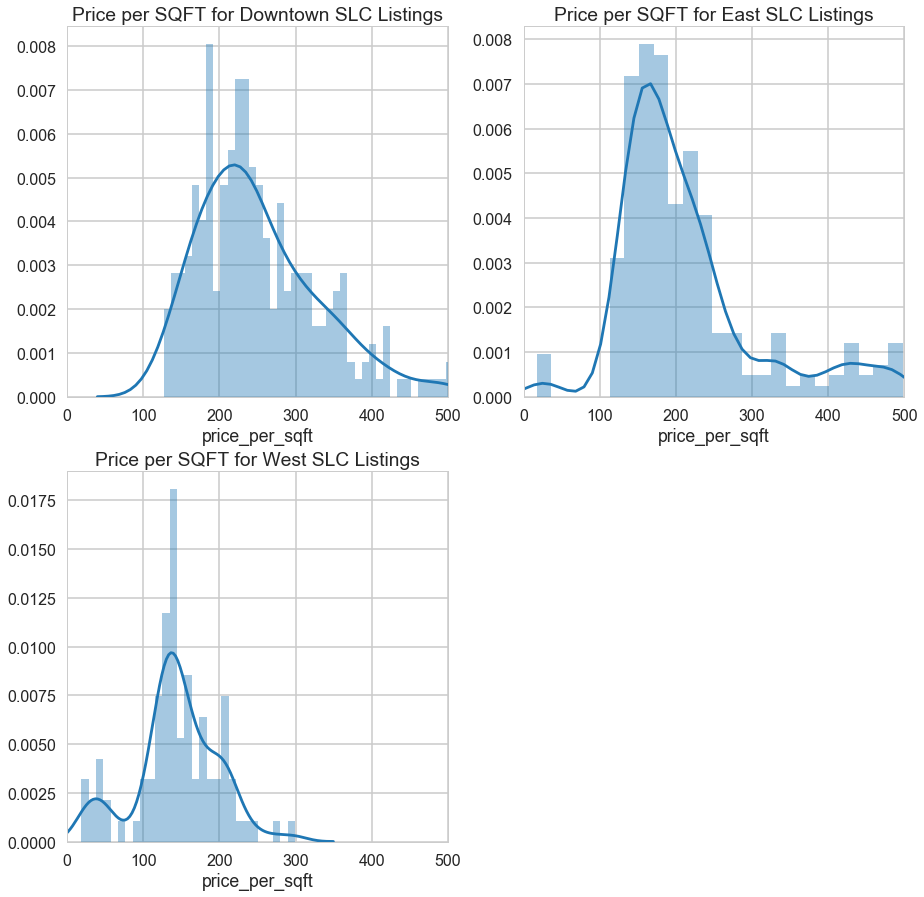

In [42]:
# plotting the price per sqft across west, east, and downtown neighborhoods
data_slc = address_data[address_data['neighborhood'] == 'Downtown SLC']
data_slc_east = address_data[(address_data['neighborhood'] == 'Cottonwood') |
                            (address_data['neighborhood'] == 'Millcreek_Holladay') |
                            (address_data['neighborhood'] == 'Emigration Canyo,') ]
data_slc_west = address_data[(address_data['neighborhood'] == 'Murray') |
                            (address_data['neighborhood'] == 'North SLC') |
                            (address_data['neighborhood'] == 'Taylorsville_Midvale') ]

data_slc = data_slc[np.isnan(data_slc.price_per_sqft)==False]
data_slc_east = data_slc_east[np.isnan(data_slc_east.price_per_sqft)==False]
data_slc_west = data_slc_west[np.isnan(data_slc_west.price_per_sqft)==False]


sns.set_style("whitegrid")
sns.set_context("poster")

fig = plt.figure(figsize=[15, 15])

x = 0.3   # set a proportion of lisiting to split bin by to correct for different sample set sizes
lower = 0   # set lower x axis limit  
upper = 500  # upper lower x axis limit

fig.add_subplot(221)   #top left
plot1 =data_slc['price_per_sqft']
sns.distplot(plot1, bins = int(len(data_slc)*x), kde=True).set_title('Price per SQFT for Downtown SLC Listings')
plt.xlim(lower, upper)


fig.add_subplot(222)   #top right
plot2 =data_slc_east['price_per_sqft']
sns.distplot(plot2, bins = int(len(data_slc_east)*x) , kde=True).set_title('Price per SQFT for East SLC Listings')
plt.xlim(lower, upper)


fig.add_subplot(223)   #top right
plot3 =data_slc_west['price_per_sqft']
sns.distplot(plot3, bins= int(len(data_slc_west)*x) , kde=True).set_title('Price per SQFT for West SLC Listings')
plt.xlim(lower, upper)

plt.show()

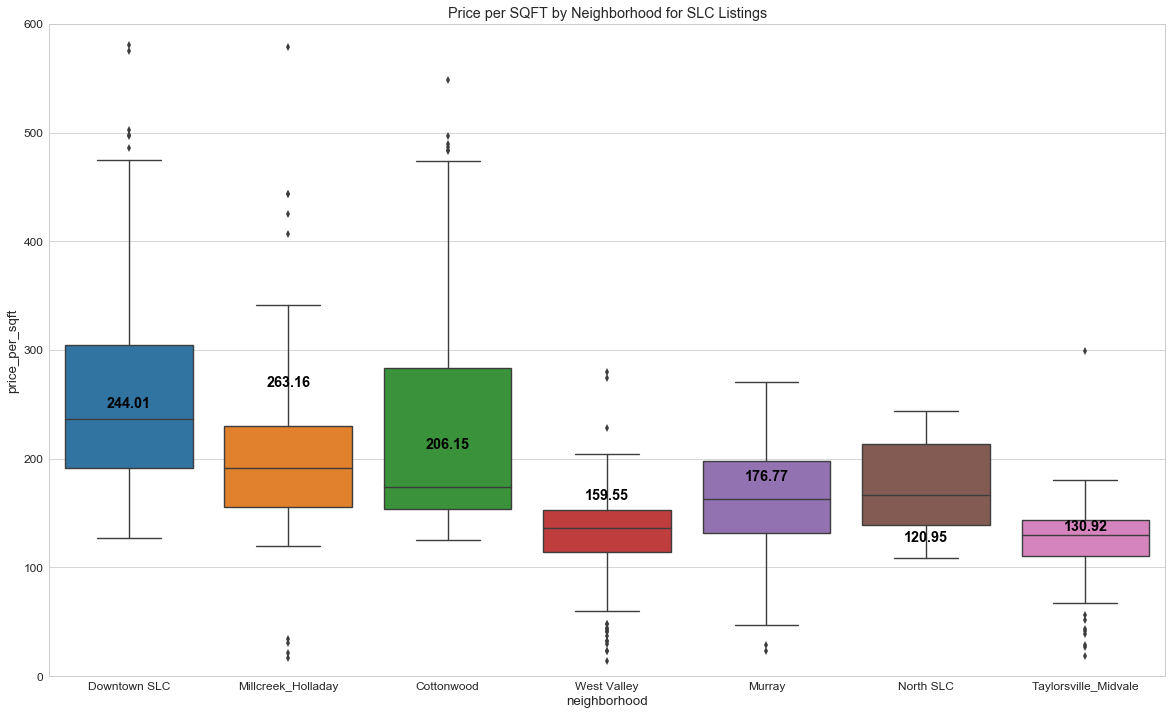

In [43]:
###### plotting the price/median price by neighborhoods

sns.set_style("whitegrid")
sns.set_context("paper", font_scale=1.5)

fig = plt.figure(figsize=[20, 12])

lower = 0   # set lower x axis limit  
upper = 600  # upper lower x axis limit

fig.add_subplot(111)   #top left
ax = sns.boxplot(x="neighborhood", y="price_per_sqft", data=address_data)

means = address_data.groupby(['neighborhood'])['price_per_sqft'].mean().values
means_labels = [str(np.round(s, 2)) for s in means]

pos = range(len(means))
for tick,label in zip(pos,ax.get_xticklabels()):
    ax.text(pos[tick], means[tick], means_labels[tick], 
            horizontalalignment='center', va = 'bottom', size='medium', color='black', weight='bold')
ax.set_title('Price per SQFT by Neighborhood for SLC Listings')
plt.ylim(lower, upper)

plt.show()

### generate a categorical variable for sqft

In [44]:
size_type_dict = {}
for column, item in address_data['sqft'].iteritems():
    if item < 1200:
        size_type = 'small'
        size_type_dict[column] = size_type
    elif item > 2400:
        size_type = 'large'
        size_type_dict[column] = size_type
    else:
        size_type = 'medium'
        size_type_dict[column] = size_type
        
size_type_dict_df = pd.DataFrame.from_dict(size_type_dict, orient='index')
size_type_dict_df.columns = ['size_type']

In [45]:
# join size_type to the existing data frame
address_data = address_data.join(size_type_dict_df, how='left')

In [46]:
address_data.head()

,title,address,city,state,postal_code,price,facts and features,url,beds,baths,sqft,neighborhood,region,price_per_sqft,size_type
zpid,,,,,,,,,,,,,,,
2090375808,Condo For Sale,5 N 500 W # 917,SALT LAKE CITY,UT,84101,"265,000.00","1 bd , 1 ba , 753 sqft",https://www.zillow.com/homedetails/5-N-500-W-9...,1.00,1.00,753.00,Downtown SLC,Downtown-SLC,351.93,small
2090452983,For Sale by Owner,500 W 500 S Parc At Gtwy # 817,SALT LAKE CITY,UT,84101,"245,000.00","1 bd , 1 ba , 763 sqft",https://www.zillow.com/homedetails/500-W-500-S...,1.00,1.00,763.00,Downtown SLC,Downtown-SLC,321.10,small
83826154,Condo For Sale,328 W 200 S APT 402,SALT LAKE CITY,UT,84101,"319,900.00","1 bd , 1 ba , 893 sqft",https://www.zillow.com/homedetails/328-W-200-S...,1.00,1.00,893.00,Downtown SLC,Downtown-SLC,358.23,small
65733953,Condo For Sale,5 S 500 W UNIT 1116,SALT LAKE CITY,UT,84101,"268,850.00","1 bd , 1 ba , 750 sqft",https://www.zillow.com/homedetails/5-S-500-W-U...,1.00,1.00,750.00,Downtown SLC,Downtown-SLC,358.47,small
65729920,House For Sale,5 S 500 W UNIT 1015,SALT LAKE CITY,UT,84101,"419,000.00","2 bds , 2 ba , 1,160 sqft",https://www.zillow.com/homedetails/5-S-500-W-U...,2.00,2.00,"1,160.00",Downtown SLC,Downtown-SLC,361.21,small


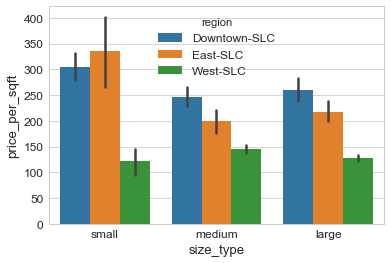

In [47]:
ax = sns.barplot(x="size_type", y="price_per_sqft", hue = 'region', data=address_data)

In [48]:
#plotting sqft by size_type
fig = plt.figure(figsize=[5,5])
ax = sns.barplot(x="region", y="sqft", color = 'region', data=address_data)
plt.title('Square Footage by size_type', y=1, fontsize=20)
plt.show()

ValueError: Invalid RGBA argument: 'region'

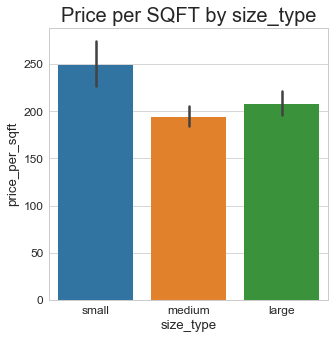

In [49]:
#plotting price per sqft by size_type
fig = plt.figure(figsize=[5,5])
ax = sns.barplot(x="size_type", y="price_per_sqft", data=address_data)
plt.title('Price per SQFT by size_type', y=1, fontsize=20)
plt.show()

In [50]:
address_data.groupby('neighborhood', group_keys=False)['size_type'].value_counts()

neighborhood          size_type
Cottonwood            large         69
                      medium        18
                      small         13
Downtown SLC          medium       134
                      large         91
                      small         57
Millcreek_Holladay    large         90
                      medium        44
                      small          4
Murray                large         19
                      medium        17
                      small          7
North SLC             medium        10
                      large          5
Taylorsville_Midvale  medium        30
                      large         10
                      small          8
West Valley           medium        91
                      large         41
                      small         21
Name: size_type, dtype: int64

## Exporting the Cleaned, Processed Active Listing Data

Here I exported the data frame to a csv so the fully processed data could be imported to the project overview notebook for summary visualizations.

In [51]:
address_data.to_csv('zillow_slc_current_listings_processed.csv')

# Plot size and bedroom count to get a good approximation for my further analysis

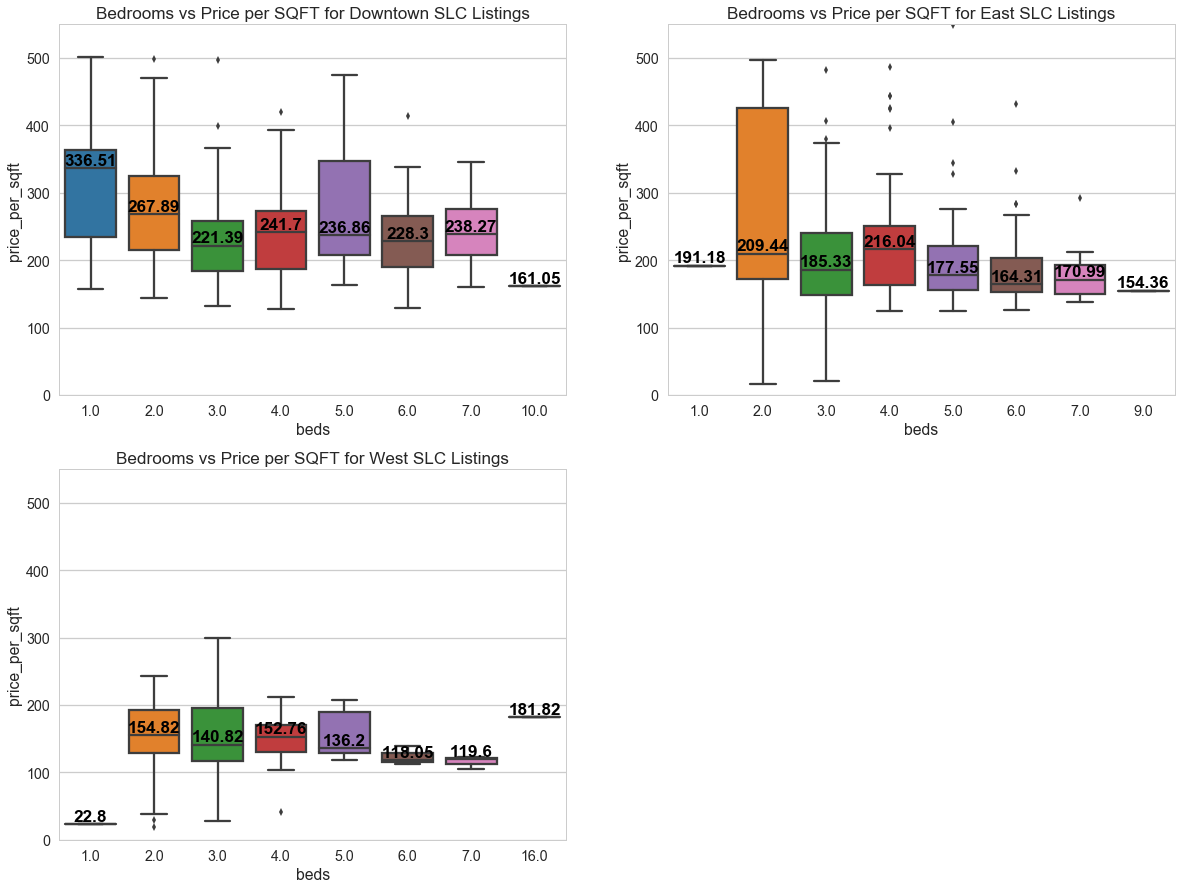

In [52]:
# plotting the price per sqft across west, east, and downtown neighborhoods
data_slc = address_data[address_data['neighborhood'] == 'Downtown SLC']
data_slc_east = address_data[(address_data['neighborhood'] == 'Cottonwood') |
                            (address_data['neighborhood'] == 'Millcreek_Holladay') |
                            (address_data['neighborhood'] == 'Emigration Canyon,') ]
data_slc_west = address_data[(address_data['neighborhood'] == 'Murray') |
                            (address_data['neighborhood'] == 'North SLC') |
                            (address_data['neighborhood'] == 'Taylorsville_Midvale') ]

data_slc = data_slc[np.isnan(data_slc.price_per_sqft)==False]
data_slc_east = data_slc_east[np.isnan(data_slc_east.price_per_sqft)==False]
data_slc_west = data_slc_west[np.isnan(data_slc_west.price_per_sqft)==False]


sns.set_style("whitegrid")
sns.set_context("talk", font_scale=1.1)

fig = plt.figure(figsize=[20, 15])

lower = 0   # set lower x axis limit  
upper = 550  # upper lower x axis limit

# first plot
fig.add_subplot(221)   #top left
ax = sns.boxplot(x="beds", y="price_per_sqft", data=data_slc)

medians = data_slc.groupby(['beds'])['price_per_sqft'].median().values
median_labels = [str(np.round(s, 2)) for s in medians]

pos = range(len(medians))
for tick,label in zip(pos,ax.get_xticklabels()):
    ax.text(pos[tick], medians[tick] + 0.5, median_labels[tick], 
            horizontalalignment='center', va = 'bottom', size='medium', color='black', weight='bold')
ax.set_title('Bedrooms vs Price per SQFT for Downtown SLC Listings')
plt.ylim(lower, upper)

# second plot
fig.add_subplot(222)   #top right
ax = sns.boxplot(x="beds", y="price_per_sqft", data=data_slc_east)

medians = data_slc_east.groupby(['beds'])['price_per_sqft'].median().values
median_labels = [str(np.round(s, 2)) for s in medians]

pos = range(len(medians))
for tick,label in zip(pos,ax.get_xticklabels()):
    ax.text(pos[tick], medians[tick] + 0.9, median_labels[tick], 
            horizontalalignment='center', va = 'bottom', size='medium', color='black', weight='bold')
ax.set_title('Bedrooms vs Price per SQFT for East SLC Listings')
plt.ylim(lower, upper)

# third plot
fig.add_subplot(223)   #bottom right
ax = sns.boxplot(x="beds", y="price_per_sqft", data=data_slc_west)

medians = data_slc_west.groupby(['beds'])['price_per_sqft'].median().values
median_labels = [str(np.round(s, 2)) for s in medians]

pos = range(len(medians))
for tick,label in zip(pos,ax.get_xticklabels()):
    ax.text(pos[tick], medians[tick] + 0.5, median_labels[tick], 
            horizontalalignment='center', va = 'bottom', size='medium', color='black', weight='bold')
ax.set_title('Bedrooms vs Price per SQFT for West SLC Listings')
plt.ylim(lower, upper)


plt.show()

(0, 800)

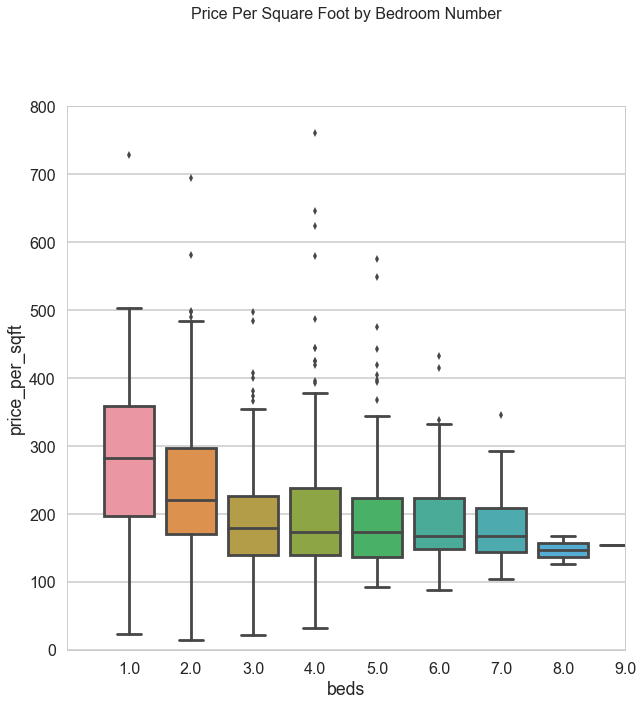

In [53]:
#make the axes fonts bigger
sns.set_context("poster")


fig = plt.figure(figsize=[10, 10])

ax = sns.boxplot(x="beds", y="price_per_sqft", data=address_data)
plt.title('Price Per Square Foot by Bedroom Number', y=1.15, fontsize=16)
plt.xlim(-1, 8)
plt.ylim(0, 800)

(0, 800)

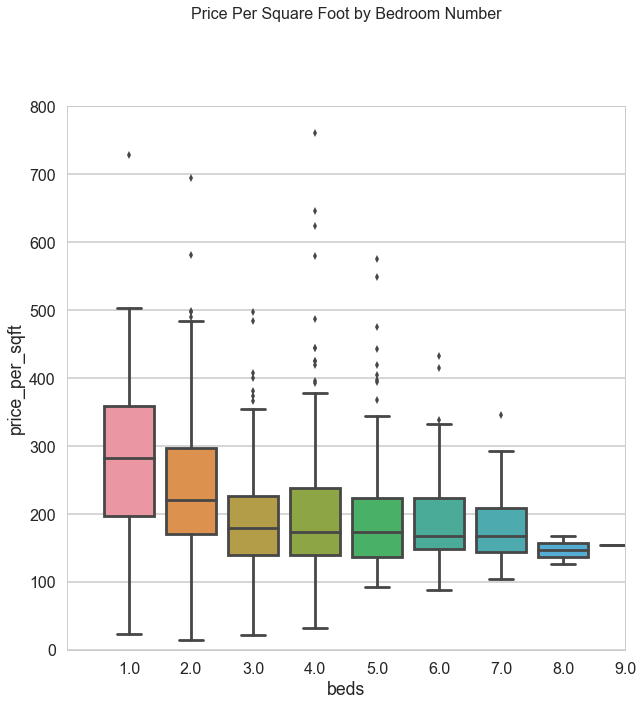

In [54]:
#make the axes fonts bigger
sns.set_context("poster")


fig = plt.figure(figsize=[10, 10])

ax = sns.boxplot(x="beds", y="price_per_sqft", data=address_data)
plt.title('Price Per Square Foot by Bedroom Number', y=1.15, fontsize=16)
plt.xlim(-1, 8)
plt.ylim(0, 800)

(0, 10000)

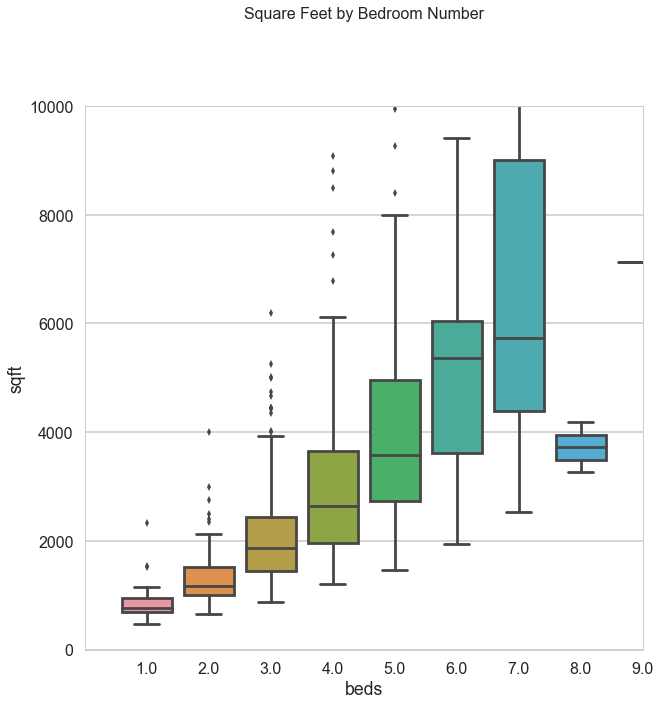

In [55]:
#make the axes fonts bigger
sns.set_context("poster")


fig = plt.figure(figsize=[10, 10])

ax = sns.boxplot(x="beds", y="sqft", data=address_data)
plt.title('Square Feet by Bedroom Number', y=1.15, fontsize=16)
plt.xlim(-1, 8)
plt.ylim(0, 10000)

(0, 8000)

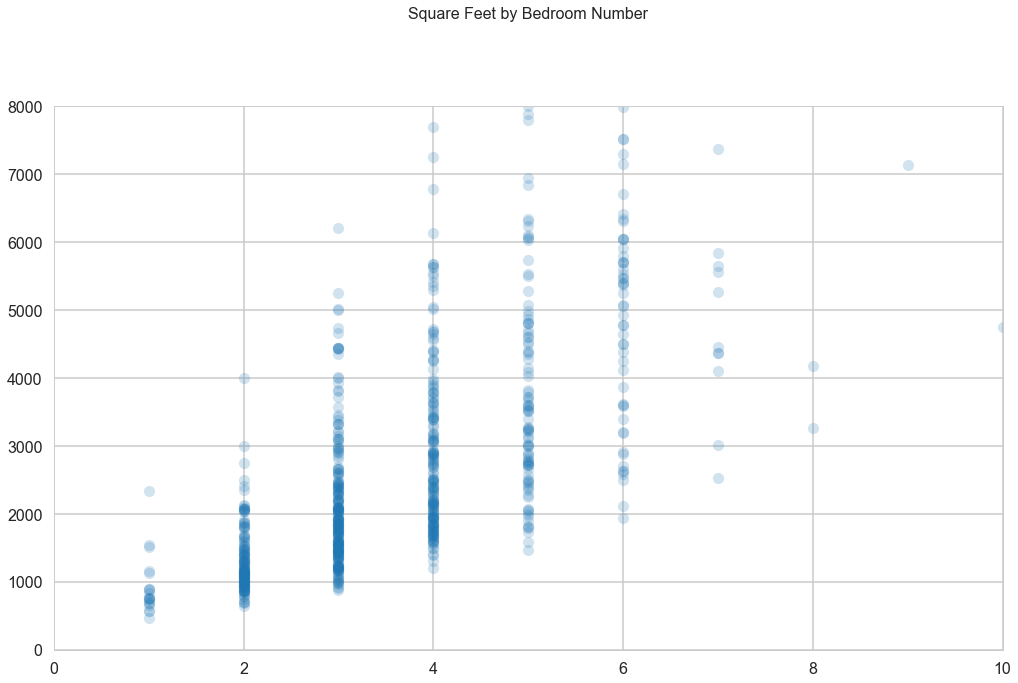

In [56]:
y=address_data['sqft']
x=address_data['beds']

#make the axes fonts bigger
sns.set_context("poster")
sns.set_context("poster")
fig = plt.figure(figsize=[17, 10])
ax = fig.add_subplot(111)

plt.plot(x,y, 'o', alpha=0.2)

plt.title('Square Feet by Bedroom Number', y=1.15, fontsize=16)
plt.xlim(0, 10)
plt.ylim(0, 8000)

In [57]:
sqft_by_beds = (address_data.groupby('beds')['sqft'].describe()).reset_index()

(0, 8000)

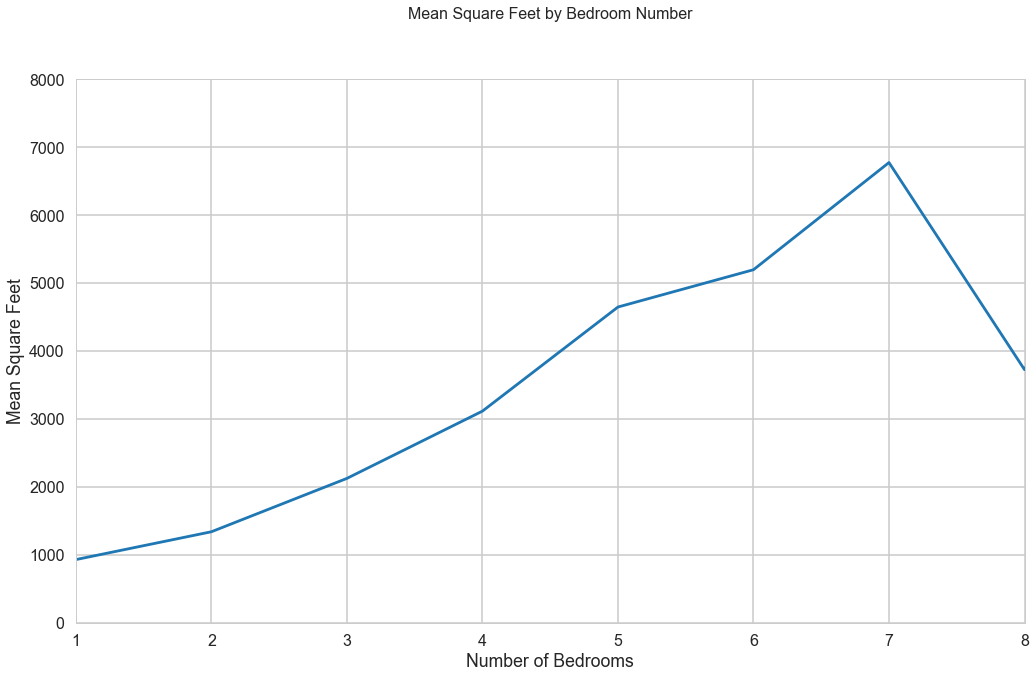

In [58]:
y=(address_data.groupby('beds')['sqft'].describe()).reset_index()['mean']
x=(address_data.groupby('beds')['sqft'].describe()).reset_index()['beds']

#make the axes fonts bigger
sns.set_context("poster")
fig = plt.figure(figsize=[17, 10])
ax = fig.add_subplot(111)

plt.plot(x,y)
plt.ylabel('Mean Square Feet')
plt.xlabel('Number of Bedrooms')

plt.title('Mean Square Feet by Bedroom Number', y=1.1, fontsize=16)
plt.xlim(1, 8)
plt.ylim(0, 8000)

In [59]:
address_data.groupby(['beds', 'baths'])['sqft'].describe()

count                 mean                  std  \
beds  baths                                                                  
 1.00  1.00                18.00               816.61               252.31   
       2.00                 1.00             1,511.00                  nan   
       3.00                 1.00             2,336.00                  nan   
 2.00  1.00                39.00             1,094.26               342.16   
       2.00                79.00             1,306.56               359.36   
       2.50                 1.00             3,000.00                  nan   
       3.00                11.00             2,174.82               690.87   
       4.00                 1.00             2,491.00                  nan   
 3.00  1.00                31.00             1,522.16               421.96   
       1.50                 1.00             1,976.00                  nan   
       2.00                92.00             1,692.91               506.17   
       2.50                 3.00             1,761.33                57.84   
       3.00                74.00             2,703.49               955.60   
       3.50                 1.00             1,812.00                  nan   
       4.00                 8.00             3,326.25               953.79   
       5.00                 1.00             5,000.00                  nan   
       7.00                 1.00             6,200.00                  nan   
 4.00  1.00                 4.00             1,685.50                77.41   
       2.00                51.00             1,999.47               488.79   
       2.50                 2.00             1,881.00               380.42   
       3.00                55.00             2,826.04               791.68   
       4.00                39.00             3,545.72             1,068.01   
       5.00                12.00             5,672.67             1,129.32   
       6.00                 6.00             7,616.17             2,508.02   
       7.00                 1.00            10,452.00                  nan   
 5.00  1.00                 3.00             2,098.00               582.13   
       2.00                14.00             2,355.86               622.94   
       3.00                35.00             3,197.54               846.63   
       4.00                25.00             3,956.92             1,026.86   
       5.00                 7.00             5,373.29               985.45   
       5.50                 1.00             7,884.00                  nan   
       6.00                 9.00             6,353.22             1,218.55   
       7.00                 5.00             9,314.40             2,327.65   
       9.00                 2.00            12,069.00             3,973.94   
      16.00                 2.00            27,428.00             7,120.57   
 6.00  2.00                 2.00             3,047.00               193.75   
       3.00                14.00             3,483.21             1,040.62   
       4.00                13.00             4,568.62               894.47   
       5.00                15.00             6,110.00               828.86   
       6.00                 5.00             6,140.20             1,339.26   
       7.00                 7.00             8,208.71               996.63   
 7.00  2.75                 1.00             2,530.00                  nan   
       4.00                 6.00             5,256.17             2,597.71   
       5.00                 5.00             5,749.60             1,071.30   
       6.00                 1.00             8,655.00                  nan   
       7.00                 3.00             9,587.33               401.26   
       9.00                 2.00            10,817.50             3,058.24   
 8.00  4.00                 2.00             3,723.00               643.47   
 9.00  5.00                 1.00             7,126.00                  nan   
10.00  5.00                 1.00             4,75

In [60]:
address_data.groupby('title')['beds'].describe()

,count,mean,std,min,25%,50%,75%,max
title,,,,,,,,
Apartment For Sale,28.00,4.64,2.80,2.00,3.00,4.00,5.25,16.00
Auction,8.00,3.25,0.89,2.00,3.00,3.00,3.25,5.00
Coming Soon,1.00,3.00,nan,3.00,3.00,3.00,3.00,3.00
Condo For Sale,115.00,2.30,0.84,1.00,2.00,2.00,3.00,5.00
For Sale by Owner,46.00,3.35,1.18,1.00,3.00,4.00,4.00,5.00
Foreclosure,2.00,4.00,1.41,3.00,3.50,4.00,4.50,5.00
Home For Sale,24.00,2.79,0.72,1.00,2.00,3.00,3.00,4.00
House For Sale,444.00,4.13,1.34,1.00,3.00,4.00,5.00,10.00
Lot/Land For Sale,0.00,nan,nan,nan,nan,nan,nan,nan


In [61]:
size_by_zip = address_data.groupby('city')['sqft'].describe()
size_by_zip.sort_values(by=['mean'], ascending = False)

,count,mean,std,min,25%,50%,75%,max
city,,,,,,,,
OTHER CITY UTAH,1.00,"8,655.00",nan,"8,655.00","8,655.00","8,655.00","8,655.00","8,655.00"
HOLLADAY,43.00,"5,221.26","4,886.59","1,458.00","2,893.50","4,013.00","5,619.00","32,463.00"
COTTONWOOD HEIGHTS,9.00,"5,194.89","1,882.31","2,722.00","3,668.00","5,469.00","6,414.00","8,001.00"
MILLCREEK,13.00,"3,223.77","1,182.56","1,348.00","2,775.00","3,148.00","3,794.00","5,249.00"
NORTH SALT LAKE,5.00,"3,014.60","1,641.85","1,380.00","1,920.00","2,602.00","3,635.00","5,536.00"
SALT LAKE CITY,491.00,"2,845.05","2,254.18",471.00,"1,444.00","2,100.00","3,519.00","22,393.00"
MURRAY,21.00,"2,818.81","2,028.11",658.00,"1,391.00","1,864.00","3,796.00","8,800.00"
BOUNTIFUL,3.00,"2,786.00",944.36,"1,957.00","2,272.00","2,587.00","3,200.50","3,814.00"
KEARNS,2.00,"2,457.50",946.82,"1,788.00","2,122.75","2,457.50","2,792.25","3,127.00"


In [62]:
address_data.groupby(['title', 'postal_code'])['sqft'].describe()

count                 mean  \
title              postal_code                                             
Apartment For Sale 84102                       2.00             1,347.00   
                   84103                       6.00             2,625.17   
                   84105                       5.00             2,339.60   
                   84106                       2.00             2,712.00   
                   84107                       2.00             5,639.50   
                   84115                       1.00             2,496.00   
                   84116                       1.00             2,000.00   
                   84117                       1.00             3,100.00   
                   84119                       3.00             2,534.67   
                   84120                       1.00             4,178.00   
                   84123                       1.00             2,372.00   
                   84124                       1.00             2,880.00   
                   84128                       2.00             2,069.00   
Auction            84104                       1.00             1,084.00   
                   84107                       1.00               908.00   
                   84118                       1.00             1,782.00   
                   84119                       1.00             2,150.00   
                   84120                       1.00             1,696.00   
                   84121                       2.00            11,730.50   
                   84129                       1.00             1,806.00   
Coming Soon        84118                       1.00             2,609.00   
Condo For Sale     84101                      23.00             1,456.17   
                   84102                      10.00             1,329.60   
                   84103                      16.00             1,476.06   
                   84104                       1.00               858.00   
                   84106                       6.00             1,140.83   
                   84107                      10.00             1,807.60   
                   84109                       2.00             3,210.50   
                   84111                       8.00             1,058.25   
                   84117                       7.00             2,240.00   
...                                             ...                  ...   
Lot/Land For Sale  84109                       0.00                  nan   
                   84115                       0.00                  nan   
                   84116                       0.00                  nan   
                   84117                       0.00                  nan   
                   84118                       0.00                  nan   
                   84121                       0.00                  nan   
                   84123                       0.00                  nan   
                   84124                       0.00                  nan   
                   84128                       0.00                  nan   
New Construction   84054                       2.00             3,118.50   
                   84103                       1.00             1,124.00   
                   84106                       7.00             2,739.57   
                   84107                       3.00             2,202.67   
                   84109                       3.00             4,611.67   
                   84114                       4.00             1,774.00   
                   84119                       5.00             2,757.20   
                   84128                       1.00             2,066.00   
Townhouse For Sale 84102                       1.00             2,863.00   
                   84106                       2.00             1,715.50   
                   84107                       4.00             2,337.75   
                  